# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

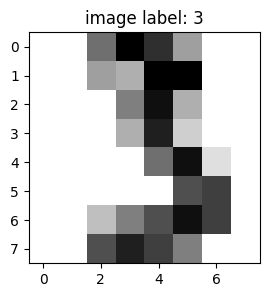

In [3]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [4]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [5]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [6]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [7]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [8]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [9]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [10]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [11]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [12]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [13]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [14]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [15]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [21]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [29]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # calculate linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b
        # softmax for probabilities
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Calculate the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        y_pred = self.forward(X)
        # Return the AVERAGE negative log likelihood (divide by number of samples)
        return nll(y_onehot, y_pred) / len(X)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b
    
# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [32]:
# Build a model and test its forward inference


n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

print(f"Training data info:")
print(f"  - Number of samples in X_train: {X_train.shape[0]}")
print(f"  - Number of features per sample: {n_features}")
print(f"  - Number of classes: {n_classes}")
print(f"  - Classes: {np.unique(y_train)}")

print("\nCreating LogisticRegression model...")
lr = LogisticRegression(n_features, n_classes)

print(f"\n✅ Model created successfully!")
print(f"  - Input size: {lr.input_size}")
print(f"  - Output size: {lr.output_size}")
print(f"  - Weight matrix shape: {lr.W.shape}")
print(f"  - Bias shape: {lr.b.shape}")

# Optional: Test forward pass on a single sample
print("\n" + "=" * 60)
print("TESTING FORWARD PASS ON FIRST SAMPLE")
print("=" * 60)

# Get first sample
first_sample = X_train[0:1]  # Keep batch dimension
true_label = y_train[0]

print(f"First sample shape: {first_sample.shape}")
print(f"True label: {true_label}")

# Run forward pass
predictions = lr.forward(first_sample)
predicted_class = np.argmax(predictions)

print(f"\nForward pass output shape: {predictions.shape}")
print(f"Predicted probabilities: {predictions[0]}")
print(f"Sum of probabilities: {np.sum(predictions):.6f}")
print(f"Predicted class: {predicted_class}")
print(f"Correct? {'✅' if predicted_class == true_label else '❌'}")

print("\n" + "=" * 60)
print("NEXT: Run the training cell (Cell 34)")
print("=" * 60)

Training data info:
  - Number of samples in X_train: 1527
  - Number of features per sample: 64
  - Number of classes: 10
  - Classes: [0 1 2 3 4 5 6 7 8 9]

Creating LogisticRegression model...

✅ Model created successfully!
  - Input size: 64
  - Output size: 10
  - Weight matrix shape: (64, 10)
  - Bias shape: (10,)

TESTING FORWARD PASS ON FIRST SAMPLE
First sample shape: (1, 64)
True label: 2

Forward pass output shape: (1, 10)
Predicted probabilities: [1.92623060e-03 8.32842637e-02 3.10712477e-03 8.36740091e-01
 5.94656433e-05 1.30245568e-03 2.10475763e-03 4.08216280e-02
 1.56250494e-02 1.50289337e-02]
Sum of probabilities: 1.000000
Predicted class: 3
Correct? ❌

NEXT: Run the training cell (Cell 34)


We can evaluate the model on an example, visualizing the prediction probabilities:

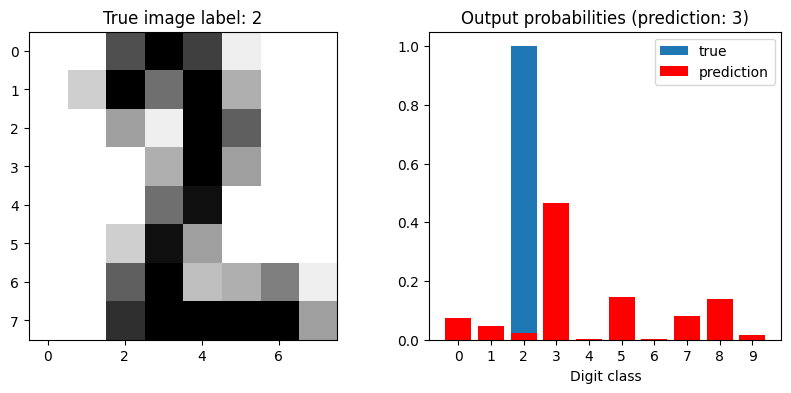

In [33]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [34]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps (avoid empty slice at i==0)
    if i > 0 and i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 100: 5
Average NLL over the last 100 samples at step 200: 2
Average NLL over the last 100 samples at step 300: 1
Average NLL over the last 100 samples at step 400: 2
Average NLL over the last 100 samples at step 500: 1
Average NLL over the last 100 samples at step 600: 0
Average NLL over the last 100 samples at step 700: 1
Average NLL over the last 100 samples at step 800: 1
Average NLL over the last 100 samples at step 900: 2
Average NLL over the last 100 samples at step 1000: 1
Average NLL over the last 100 samples at step 1100: 1
Average NLL over the last 100 samples at step 1200: 3
Average NLL over the last 100 samples at step 1300: 2
Average NLL over the last 100 samples at step 1400: 0
Average NLL over the last 100 samples at step 1500: 1


Evaluate the trained model on the first example:

In [35]:
# Test multiple examples
print("=" * 60)
print("TESTING MULTIPLE EXAMPLES")
print("=" * 60)

for idx in range(5):  # Test first 5 samples
    print(f"\n--- Sample {idx} ---")
    sample = X_test[idx:idx+1]
    true = y_test[idx]
    pred = lr.predict(sample)
    probs = lr.forward(sample)
    confidence = np.max(probs[0])
    
    print(f"True: {true}, Predicted: {pred} {'✅' if pred == true else '❌'}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Top 3 classes:")
    top3 = np.argsort(probs[0])[-3:][::-1]
    for c in top3:
        print(f"   Class {c}: {probs[0][c]:.2%}")

TESTING MULTIPLE EXAMPLES

--- Sample 0 ---
True: 2, Predicted: [2] ✅
Confidence: 100.00%
Top 3 classes:
   Class 2: 100.00%
   Class 1: 0.00%
   Class 7: 0.00%

--- Sample 1 ---
True: 4, Predicted: [4] ✅
Confidence: 100.00%
Top 3 classes:
   Class 4: 100.00%
   Class 0: 0.00%
   Class 6: 0.00%

--- Sample 2 ---
True: 7, Predicted: [7] ✅
Confidence: 100.00%
Top 3 classes:
   Class 7: 100.00%
   Class 9: 0.00%
   Class 1: 0.00%

--- Sample 3 ---
True: 9, Predicted: [9] ✅
Confidence: 100.00%
Top 3 classes:
   Class 9: 100.00%
   Class 1: 0.00%
   Class 0: 0.00%

--- Sample 4 ---
True: 1, Predicted: [1] ✅
Confidence: 100.00%
Top 3 classes:
   Class 1: 100.00%
   Class 7: 0.00%
   Class 9: 0.00%


## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

SIGMOID FUNCTION TEST

Test values:
  x = -5: sigmoid = 0.0067, dsigmoid = 0.0066
  x = -2: sigmoid = 0.1192, dsigmoid = 0.1050
  x =  0: sigmoid = 0.5000, dsigmoid = 0.2500
  x =  2: sigmoid = 0.8808, dsigmoid = 0.1050
  x =  5: sigmoid = 0.9933, dsigmoid = 0.0066

Generating plot...


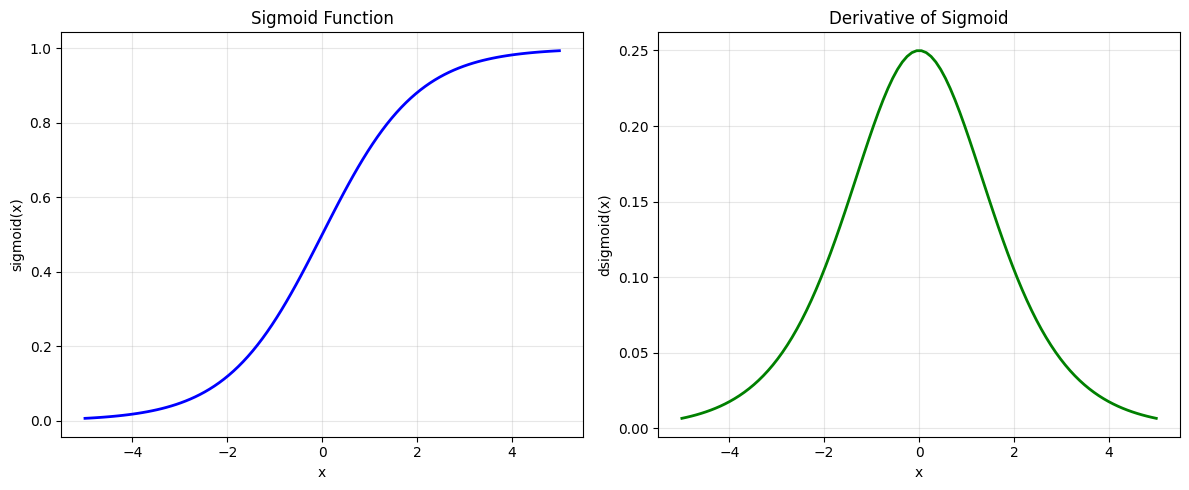

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(X):
    # Clip X to prevent overflow
    X = np.clip(X, -500, 500)
    # Calculate sigmoid
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    # Calculate sigmoid first
    s = sigmoid(X)
    # Calculate derivative
    return s * (1 - s)

# Test with values
print("=" * 50)
print("SIGMOID FUNCTION TEST")
print("=" * 50)

test_points = [-5, -2, 0, 2, 5]
print("\nTest values:")
for x in test_points:
    print(f"  x = {x:2d}: sigmoid = {sigmoid(x):.4f}, dsigmoid = {dsigmoid(x):.4f}")

# Generate plot
print("\nGenerating plot...")
x = np.linspace(-5, 5, 100)
y_sigmoid = sigmoid(x)
y_dsigmoid = dsigmoid(x)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_sigmoid, 'b-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid Function')

plt.subplot(1, 2, 2)
plt.plot(x, y_dsigmoid, 'g-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('dsigmoid(x)')
plt.title('Derivative of Sigmoid')

plt.tight_layout()
plt.show()



Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [40]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        print(f"✓ NeuralNet initialized:")
        print(f"  - Input size: {input_size}")
        print(f"  - Hidden size: {hidden_size}")
        print(f"  - Output size: {output_size}")
        print(f"  - W_h shape: {self.W_h.shape}")
        print(f"  - b_h shape: {self.b_h.shape}")
        print(f"  - W_o shape: {self.W_o.shape}")
        print(f"  - b_o shape: {self.b_o.shape}")

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h
        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        # Apply softmax (not sigmoid!) for output layer
        return softmax(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred) / len(X)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [41]:
n_hidden = 10
print("\nMODEL CONFIGURATION:")
print(f"  - Number of features (input size): {n_features}")
print(f"  - Hidden layer size: {n_hidden}")
print(f"  - Number of classes (output size): {n_classes}")

# Create the model
print("\nCreating NeuralNet model...")
model = NeuralNet(n_features, n_hidden, n_classes)

# Test on a single sample
sample_idx = 0
print(f"\nTesting on sample index: {sample_idx}")

# Get the sample
X_sample = X_train[sample_idx:sample_idx+1]  # Keep batch dimension
y_sample = y_train[sample_idx]
print(f"  Input shape: {X_sample.shape}")
print(f"  True label: {y_sample}")

# Run forward pass
print("\nRunning forward pass...")
predictions = model.forward(X_sample)
print(f"  Output shape: {predictions.shape}")
print(f"  Sum of probabilities: {np.sum(predictions[0]):.6f}")

# Get prediction
predicted_class = model.predict(X_sample)
print(f"\nPredicted class: {predicted_class}")
if predicted_class == y_sample:
    print(f"  Result: CORRECT")
else:
    print(f"  Result: INCORRECT (expected {y_sample})")

# Show probability distribution
print("\nProbability distribution across classes:")
print("-" * 40)
print("Class    Probability    %")
print("-" * 40)
for i, prob in enumerate(predictions[0]):
    marker = "*" if i == predicted_class else " "
    print(f"{marker} {i:2d}      {prob:.4f}       {prob*100:.1f}%")
print("-" * 40)

# Calculate loss
print("\nCalculating loss...")
loss_value = model.loss(X_sample, np.array([y_sample]))
print(f"  Loss: {loss_value:.6f}")

# Calculate accuracy on training set
print("\nQuick evaluation on full training set:")
train_preds = model.predict(X_train)
train_acc = np.mean(train_preds == y_train)
print(f"  Training accuracy (random init): {train_acc:.2%}")

print("\n" + "=" * 70)
print("Model test complete. The model is ready for training.")
print("=" * 70)


MODEL CONFIGURATION:
  - Number of features (input size): 64
  - Hidden layer size: 10
  - Number of classes (output size): 10

Creating NeuralNet model...
✓ NeuralNet initialized:
  - Input size: 64
  - Hidden size: 10
  - Output size: 10
  - W_h shape: (64, 10)
  - b_h shape: (10,)
  - W_o shape: (10, 10)
  - b_o shape: (10,)

Testing on sample index: 0
  Input shape: (1, 64)
  True label: 2

Running forward pass...
  Output shape: (1, 10)
  Sum of probabilities: 1.000000

Predicted class: [4]
  Result: INCORRECT (expected 2)

Probability distribution across classes:
----------------------------------------
Class    Probability    %
----------------------------------------
   0      0.0979       9.8%
   1      0.1130       11.3%
   2      0.0871       8.7%
   3      0.0862       8.6%
*  4      0.1202       12.0%
   5      0.0991       9.9%
   6      0.1054       10.5%
   7      0.0927       9.3%
   8      0.1049       10.5%
   9      0.0936       9.4%
-------------------------------

In [42]:
model.loss(X_train, y_train)

np.float64(2.3088219587430108)

In [43]:
model.accuracy(X_train, y_train)

np.float64(0.0733464309102816)

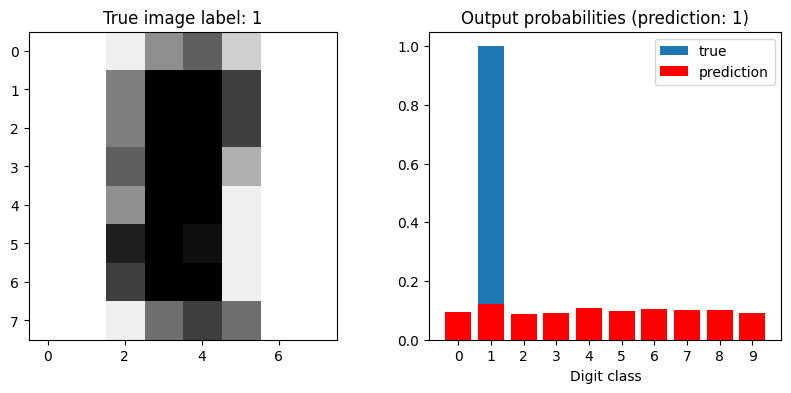

In [44]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [45]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30882, train acc: 0.073, test acc: 0.074
Epoch #1, train loss: 1.78161, train acc: 0.434, test acc: 0.400
Epoch #2, train loss: 1.28012, train acc: 0.712, test acc: 0.681
Epoch #3, train loss: 0.91842, train acc: 0.836, test acc: 0.837
Epoch #4, train loss: 0.69855, train acc: 0.870, test acc: 0.859
Epoch #5, train loss: 0.56301, train acc: 0.891, test acc: 0.867
Epoch #6, train loss: 0.47102, train acc: 0.910, test acc: 0.889
Epoch #7, train loss: 0.40062, train acc: 0.925, test acc: 0.904
Epoch #8, train loss: 0.34744, train acc: 0.935, test acc: 0.919
Epoch #9, train loss: 0.30832, train acc: 0.947, test acc: 0.926
Epoch #10, train loss: 0.27892, train acc: 0.957, test acc: 0.937
Epoch #11, train loss: 0.25594, train acc: 0.959, test acc: 0.941
Epoch #12, train loss: 0.23757, train acc: 0.961, test acc: 0.944
Epoch #13, train loss: 0.22275, train acc: 0.962, test acc: 0.944
Epoch #14, train loss: 0.21069, train acc: 0.965, test acc: 0.944
Epoch #15, train 

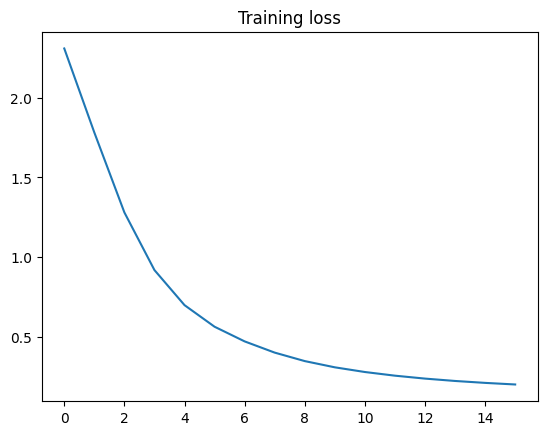

In [46]:
plt.plot(losses)
plt.title("Training loss");

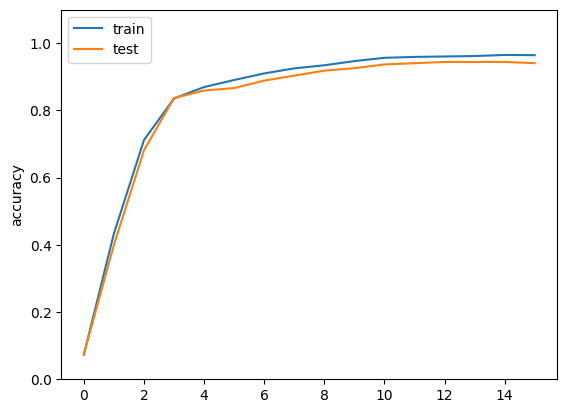

In [47]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

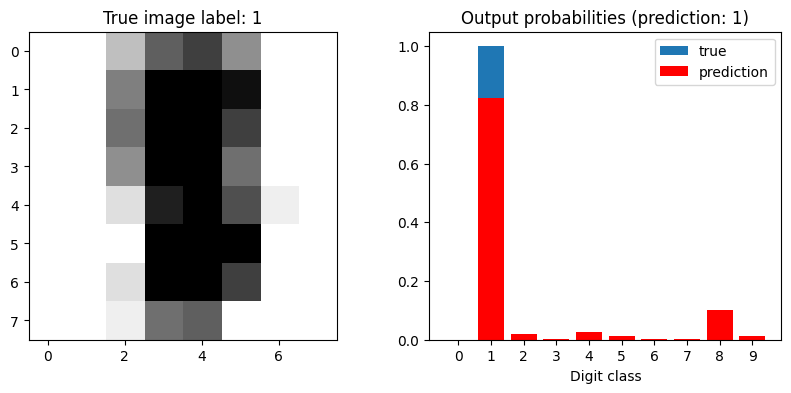

In [48]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?


Top 9 worst predictions (highest loss):
------------------------------------------------------------
Rank   Sample   True   Pred   Loss       Confidence
------------------------------------------------------------
1      107      5      9      4.5113     78.70%
2      99       4      1      3.6421     57.34%
3      180      6      0      3.1957     47.22%
4      44       6      0      2.7955     77.66%
5      69       8      5      2.6354     53.45%
6      105      1      9      2.4278     52.84%
7      123      8      2      2.4056     74.78%
8      26       8      9      2.1871     48.06%
9      252      8      9      1.8069     34.84%
------------------------------------------------------------

DISPLAY WORST PREDICTIONS

--- Worst Prediction #1 (Sample 107) ---
True class: 5, Predicted: 9
Loss: 4.5113

--- Worst Prediction #2 (Sample 99) ---
True class: 4, Predicted: 1
Loss: 3.6421

--- Worst Prediction #3 (Sample 180) ---
True class: 6, Predicted: 0
Loss: 3.1957

--- Worst Predic

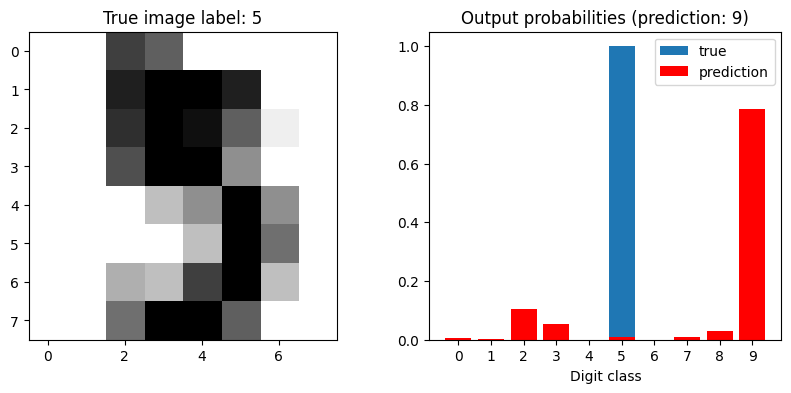

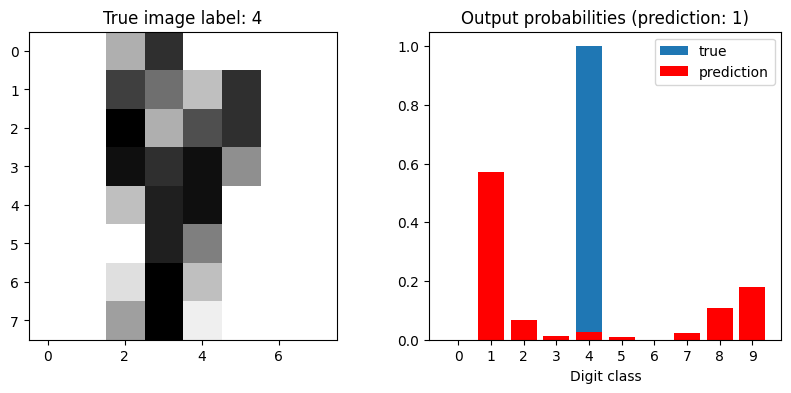

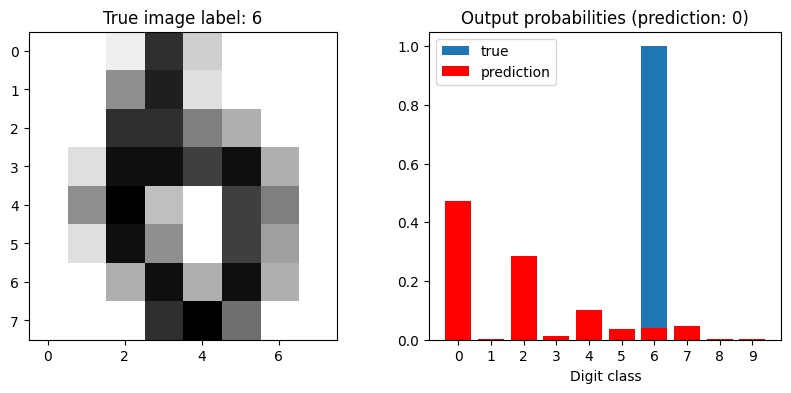

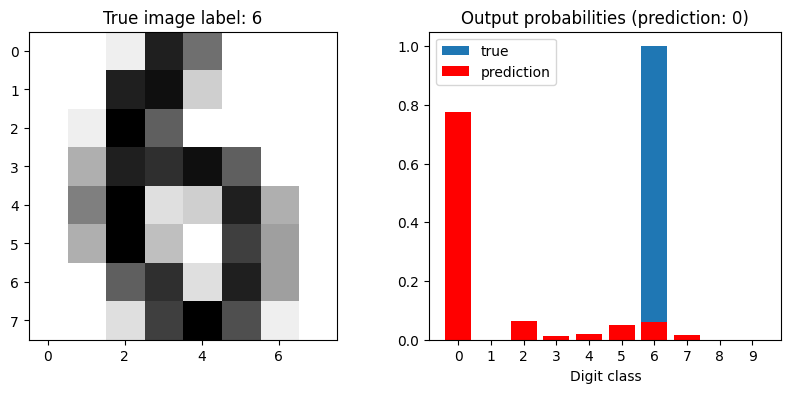

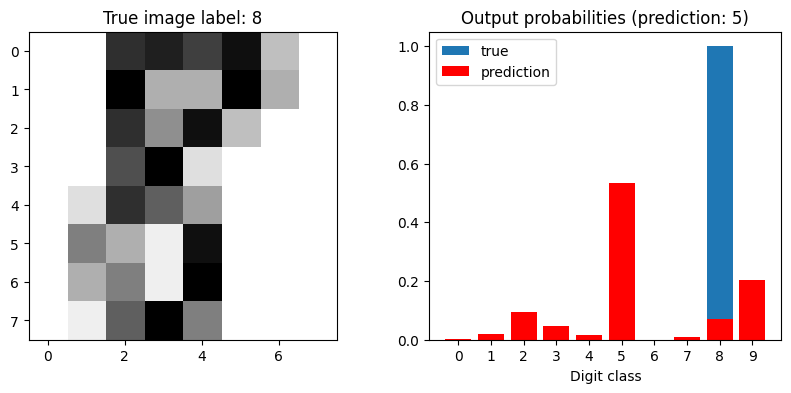

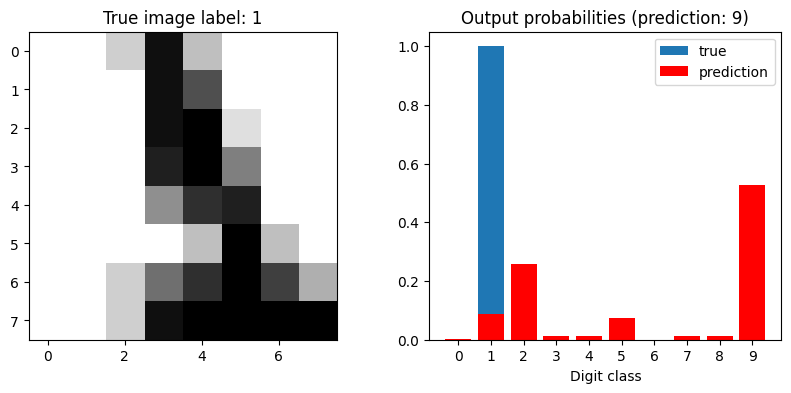

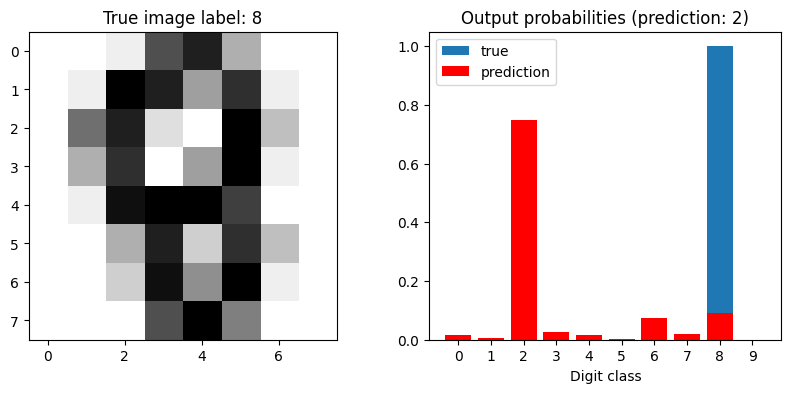

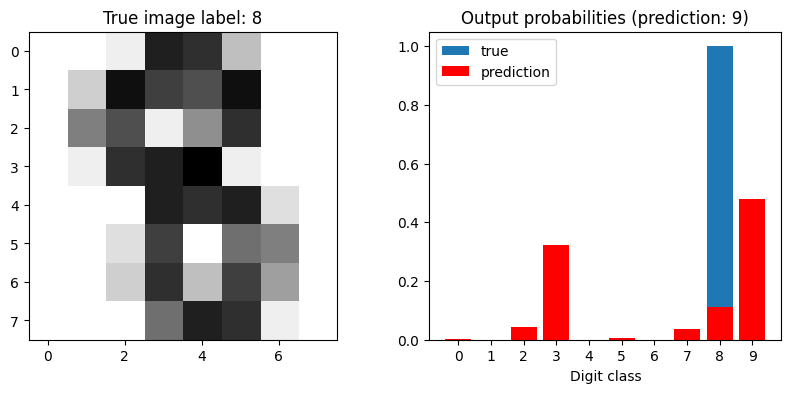

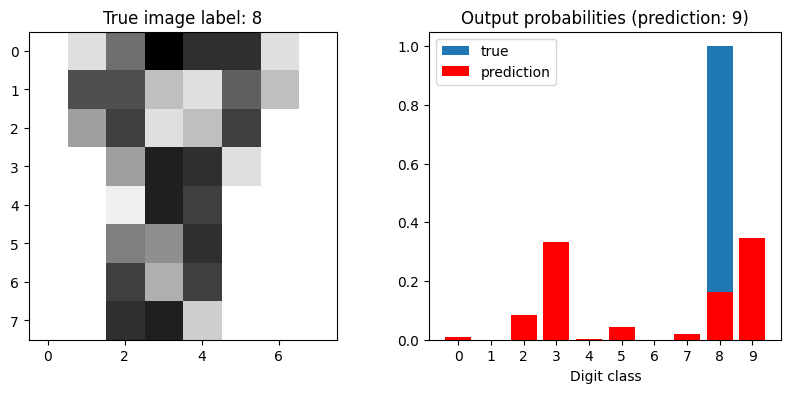

In [49]:


# Get predictions on test set
test_predictions = model.forward(X_test)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = y_test

# Calculate loss for each test sample individually
sample_losses = []
for i in range(len(X_test)):
    # Get single sample
    x_sample = X_test[i:i+1]
    y_sample = np.array([y_test[i]])
    
    # Calculate loss for this sample
    loss = model.loss(x_sample, y_sample)
    sample_losses.append(loss)

sample_losses = np.array(sample_losses)

# Find indices of worst predictions (highest loss)
# Get indices sorted by loss (highest first)
worst_indices = np.argsort(sample_losses)[-9:][::-1]  # Top 9 worst

print(f"\nTop 9 worst predictions (highest loss):")
print("-" * 60)
print(f"{'Rank':<6} {'Sample':<8} {'True':<6} {'Pred':<6} {'Loss':<10} {'Confidence'}")
print("-" * 60)

for rank, idx in enumerate(worst_indices):
    true = true_classes[idx]
    pred = predicted_classes[idx]
    loss = sample_losses[idx]
    confidence = np.max(test_predictions[idx])
    print(f"{rank+1:<6} {idx:<8} {true:<6} {pred:<6} {loss:<10.4f} {confidence:.2%}")

print("-" * 60)

print("\n" + "=" * 70)
print("DISPLAY WORST PREDICTIONS")
print("=" * 70)

for i, idx in enumerate(worst_indices):
    print(f"\n--- Worst Prediction #{i+1} (Sample {idx}) ---")
    print(f"True class: {true_classes[idx]}, Predicted: {predicted_classes[idx]}")
    print(f"Loss: {sample_losses[idx]:.4f}")
    plot_prediction(model, sample_idx=idx)

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [56]:


print("\n1. DIFFERENT LEARNING RATES")
print("-" * 30)

learning_rates = [0.1, 0.01, 0.001]

for lr in learning_rates:
    print(f"\nLearning rate = {lr}")
    model = NeuralNet(n_features, hidden_size=10, output_size=n_classes)
    
    # Train for a few epochs
    for epoch in range(5):
        for x, y in zip(X_train, y_train):
            model.train(x, y, lr)
    
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test accuracy:  {test_acc:.3f}")


print("\n2. DIFFERENT HIDDEN LAYER SIZES")
print("-" * 30)

hidden_sizes = [5, 10, 20]

for h in hidden_sizes:
    print(f"\nHidden size = {h}")
    model = NeuralNet(n_features, hidden_size=h, output_size=n_classes)
    
    for epoch in range(5):
        for x, y in zip(X_train, y_train):
            model.train(x, y, learning_rate=0.01)
    
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test accuracy:  {test_acc:.3f}")


print("\n--- ADDING SECOND HIDDEN LAYER ---")

# Simple 2-hidden-layer model (just modify the existing class)
class NeuralNet2Layer(NeuralNet):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize first hidden layer (same as before)
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1), high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size1, high=0.1, low=-0.1)
        
        # Second hidden layer
        self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2), high=0.1, low=-0.1)
        self.b_h2 = np.random.uniform(size=hidden_size2, high=0.1, low=-0.1)
        
        # Output layer
        self.W_o = np.random.uniform(size=(hidden_size2, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        
        self.input_size = input_size
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
    
    def forward(self, X):
        # First hidden layer
        Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        H1 = sigmoid(Z_h1)
        
        # Second hidden layer
        Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
        H2 = sigmoid(Z_h2)
        
        # Output layer
        Z_o = np.dot(H2, self.W_o) + self.b_o
        return softmax(Z_o)
    
    def train(self, x, y, lr):
        x = x[np.newaxis, :]
        y_onehot = one_hot(self.output_size, np.array([y]))
        
        # Forward pass (store intermediate values for backprop)
        Z_h1 = np.dot(x, self.W_h1) + self.b_h1
        H1 = sigmoid(Z_h1)
        Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
        H2 = sigmoid(Z_h2)
        Z_o = np.dot(H2, self.W_o) + self.b_o
        y_pred = softmax(Z_o)
        
        # Backward pass
        error_o = y_pred - y_onehot
        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(Z_h2)
        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(Z_h1)
        
        # Update weights
        self.W_o -= lr * np.dot(H2.T, error_o)
        self.b_o -= lr * np.sum(error_o, axis=0)
        self.W_h2 -= lr * np.dot(H1.T, error_h2)
        self.b_h2 -= lr * np.sum(error_h2, axis=0)
        self.W_h1 -= lr * np.dot(x.T, error_h1)
        self.b_h1 -= lr * np.sum(error_h1, axis=0)

model2 = NeuralNet2Layer(n_features, hidden_size1=10, hidden_size2=5, output_size=n_classes)

for epoch in range(5):
    for x, y in zip(X_train, y_train):
        model2.train(x, y, 0.01)

test_acc = model2.accuracy(X_test, y_test)
print(f"2-layer test accuracy: {test_acc:.3f}")



1. DIFFERENT LEARNING RATES
------------------------------

Learning rate = 0.1
✓ NeuralNet initialized:
  - Input size: 64
  - Hidden size: 10
  - Output size: 10
  - W_h shape: (64, 10)
  - b_h shape: (10,)
  - W_o shape: (10, 10)
  - b_o shape: (10,)
  Train accuracy: 0.100
  Test accuracy:  0.107

Learning rate = 0.01
✓ NeuralNet initialized:
  - Input size: 64
  - Hidden size: 10
  - Output size: 10
  - W_h shape: (64, 10)
  - b_h shape: (10,)
  - W_o shape: (10, 10)
  - b_o shape: (10,)
  Train accuracy: 0.109
  Test accuracy:  0.063

Learning rate = 0.001
✓ NeuralNet initialized:
  - Input size: 64
  - Hidden size: 10
  - Output size: 10
  - W_h shape: (64, 10)
  - b_h shape: (10,)
  - W_o shape: (10, 10)
  - b_o shape: (10,)
  Train accuracy: 0.930
  Test accuracy:  0.893

2. DIFFERENT HIDDEN LAYER SIZES
------------------------------

Hidden size = 5
✓ NeuralNet initialized:
  - Input size: 64
  - Hidden size: 5
  - Output size: 10
  - W_h shape: (64, 5)
  - b_h shape: (5,)
 

Best test accuracy: 89.3% with:

Learning rate: 0.001

Hidden layer size: 10

Number of hidden layers: 1

In [ ]:
"""Best test accuracy: 89.3% with:

Learning rate: 0.001

Hidden layer size: 10

Number of hidden layers: 

With more time, I would train at .001 learning rate."""